In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [4]:
class_size = 10
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [5]:
def one_hot(y, batch_size):
    oh = torch.zeros([batch_size, class_size])
    for st,idx in enumerate(y): 
        try:
            oh[st][idx] = 1 
        except:
            print ('st=', type(st), ' idx=', type(idx), idx.shape)
            raise
    return oh 

def get_random_h(cl):
    z = torch.randn((50, 16))
    oh = one_hot(y=cl, batch_size=batch_size)
    h = torch.cat((z, oh), 1) 
    return h

In [6]:
fixed_data, fixed_cl = next(iter(test_loader))
fixed_h = get_random_h(fixed_cl[:50])
fixed_z_label = torch.tensor(list(range(10))).repeat((5))

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [10]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 16
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([32*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size + class_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 512, 512, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x, y):
        self.h = self.encode(x)
        oh = one_hot(y=y, batch_size=batch_size)
        encoded_oh = torch.cat((self.h, oh), 1) 
        x = self.decode(encoded_oh)
        return x
    
    def ae_loss(self, data, label):
        
       # oh = one_hot(y=label, batch_size=batch_size)
       # 
       # encoded_oh = torch.cat((encoded, oh), 1) 
    
        output = self.forward(data, label)        
        self._reconst_loss = F.mse_loss(output, data) 
         
        encoded = self.encode(data)
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(torch.randn((batch_size, self.latent_size)))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [11]:
models = {
    'Adam Discr': Net(False, False, optim_type='Adam', lr=1e-4),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data, label)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [13]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [14]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(train_loader):
            output = {k: m.forward(data, label) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data, label)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            with torch.no_grad():
                print ("Model {}:".format(k))
                ae_data = models[k].forward(fixed_data, fixed_cl).data.numpy()
                fixed_gen = models[k].decode(fixed_h).data.numpy()
                random_gen = models[k].decode(get_random_h(fixed_z_label)).data.numpy()
                plot_mnist(ae_data, (5, 10))
                plot_mnist(fixed_gen, (5, 10)) 
                plot_mnist(random_gen, (5, 10)) 

                encoded = model.encode(fixed_data[:10])
                enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
                plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr: AE:1.6046 D:0.6832 Adam Discr+bn+dp: AE:1.8067 D:0.7052
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam Discr: AE:3.1949 D:0.0618 Adam Discr+bn+dp: AE:3.7731 D:0.0330
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam Discr: AE:4.7560 D:0.0115 Adam Discr+bn+dp: AE:4.4714 D:0.0184
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam Discr: AE:5.4497 D:0.0039 Adam Discr+bn+dp: AE:5.4365 D:0.0147
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam Discr: AE:6.0206 D:0.0033 Adam Discr+bn+dp: AE:6.0598 D:0.0024
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr: AE:6.5149 D:0.0054 Adam Discr+bn+dp: AE:6.7439 D:0.0023
Model Adam Discr:


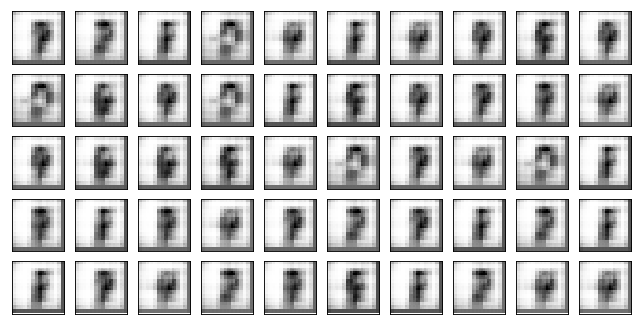

Model Adam Discr+bn+dp:


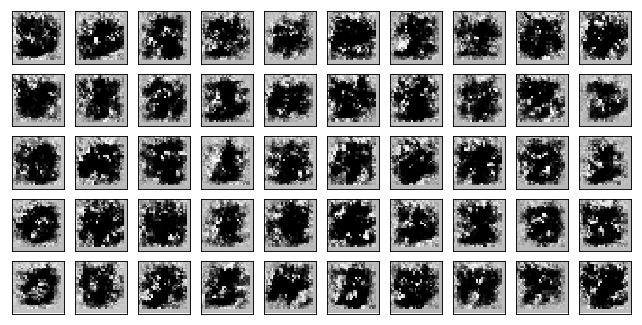

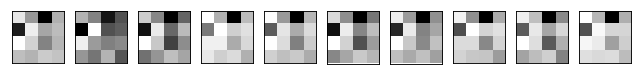

Test losses: 
Adam Discr: 1.87334132 / 31.64472961 / 0.00652746 
Adam Discr+bn+dp: 2.60353088 / 30.45904732 / 0.00808724 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr: AE:6.5852 D:0.0012 Adam Discr+bn+dp: AE:6.5122 D:0.0017
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam Discr: AE:6.8283 D:0.0013 Adam Discr+bn+dp: AE:6.9639 D:0.0011
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam Discr: AE:7.2164 D:0.0008 Adam Discr+bn+dp: AE:7.1998 D:0.0009
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam Discr: AE:7.4425 D:0.0011 Adam Discr+bn+dp: AE:7.5822 D:0.0005
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam Discr: AE:7.5284 D:0.0006 Adam Discr+bn+dp: AE:7.8000 D:0.0007
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr: AE:7.9121 D:0.0005 Adam Discr+bn+dp: AE:8.1118 D:0.0003
Model Adam Discr:


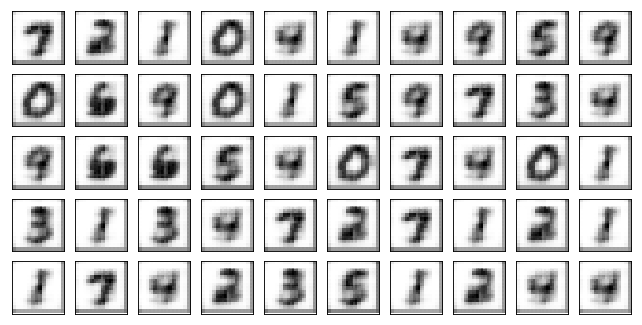

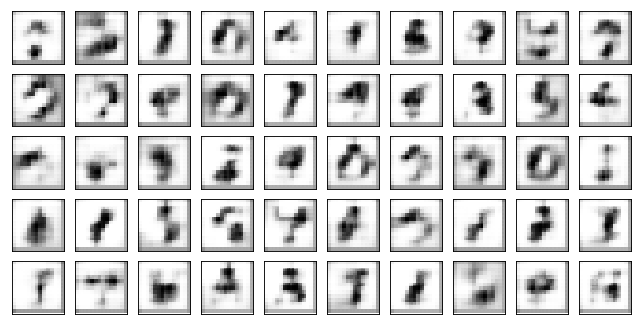

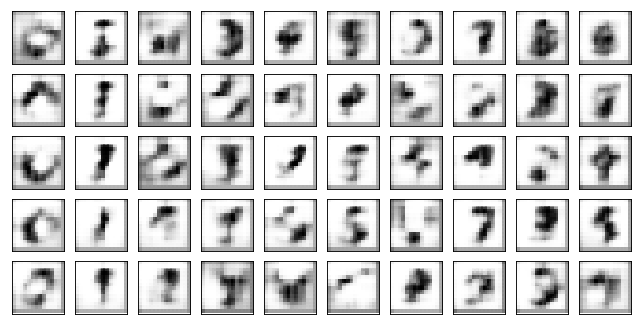

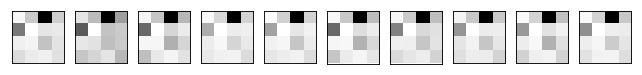

Model Adam Discr+bn+dp:


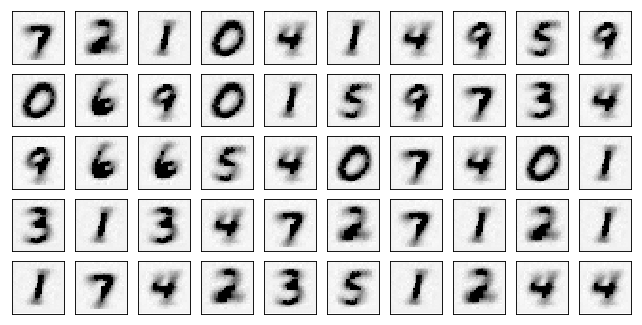

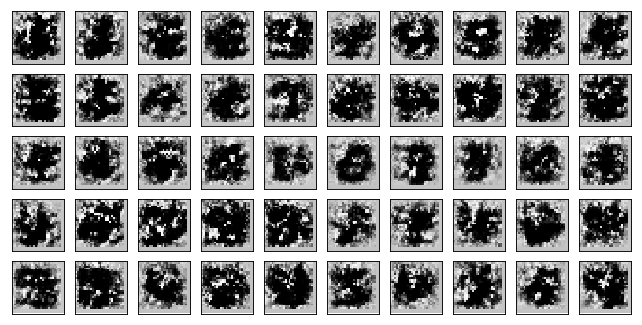

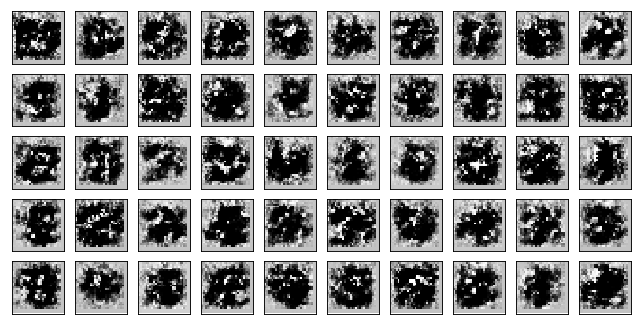

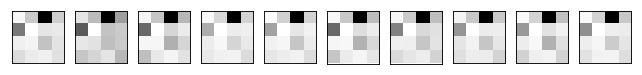

Test losses: 
Adam Discr: 1.40214825 / 38.00822830 / 0.00226051 
Adam Discr+bn+dp: 2.17622018 / 38.73156738 / 0.00191544 

Train Epoch: 3 [0/50000 (0%)]	Losses Adam Discr: AE:7.9006 D:0.0005 Adam Discr+bn+dp: AE:8.2012 D:0.0003
Train Epoch: 3 [10000/50000 (20%)]	Losses Adam Discr: AE:7.8214 D:0.0006 Adam Discr+bn+dp: AE:8.0921 D:0.0004
Train Epoch: 3 [20000/50000 (40%)]	Losses Adam Discr: AE:8.5470 D:0.0002 Adam Discr+bn+dp: AE:8.2987 D:0.0004
Train Epoch: 3 [30000/50000 (60%)]	Losses Adam Discr: AE:8.9124 D:0.0004 Adam Discr+bn+dp: AE:8.8148 D:0.0002
Train Epoch: 3 [40000/50000 (80%)]	Losses Adam Discr: AE:8.1841 D:0.0086 Adam Discr+bn+dp: AE:7.9760 D:0.0012
Train Epoch: 3 [50000/50000 (100%)]	Losses Adam Discr: AE:7.7409 D:0.0004 Adam Discr+bn+dp: AE:8.1761 D:0.0020
Model Adam Discr:


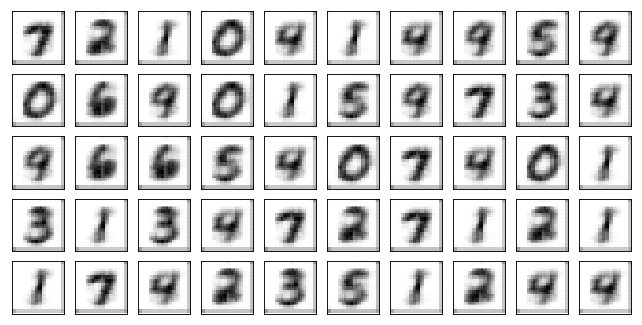

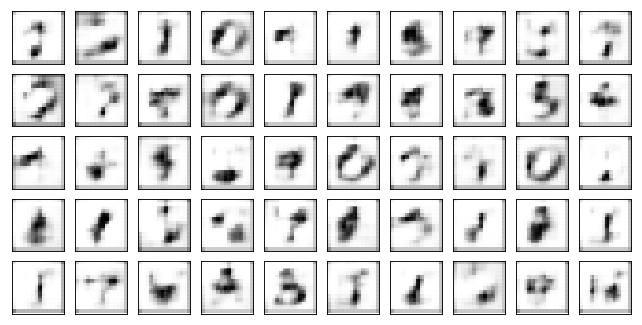

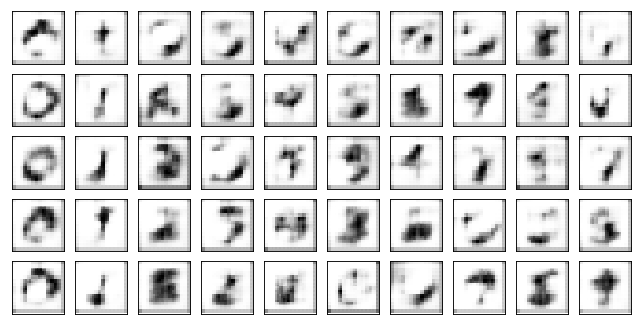

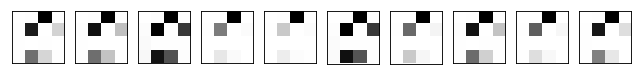

Model Adam Discr+bn+dp:


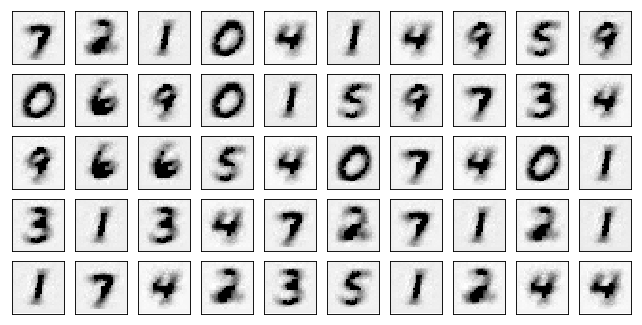

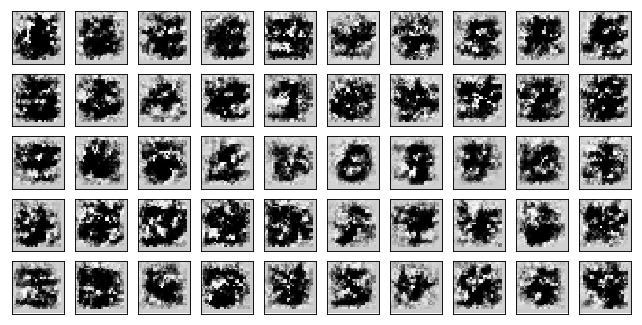

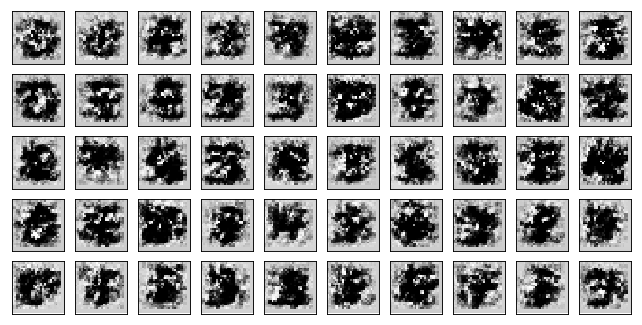

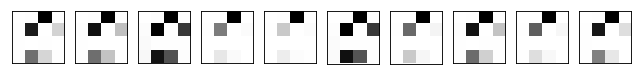

Test losses: 
Adam Discr: 1.22196949 / 40.32762909 / 0.00878270 
Adam Discr+bn+dp: 1.90262771 / 39.36677551 / 0.00353108 

Train Epoch: 4 [0/50000 (0%)]	Losses Adam Discr: AE:8.0955 D:0.0006 Adam Discr+bn+dp: AE:8.0973 D:0.0006
Train Epoch: 4 [10000/50000 (20%)]	Losses Adam Discr: AE:9.5754 D:0.0004 Adam Discr+bn+dp: AE:7.1990 D:0.0173
Train Epoch: 4 [20000/50000 (40%)]	Losses Adam Discr: AE:9.9594 D:0.0001 Adam Discr+bn+dp: AE:8.2814 D:0.0004
Train Epoch: 4 [30000/50000 (60%)]	Losses Adam Discr: AE:9.9474 D:0.0044 Adam Discr+bn+dp: AE:8.9235 D:0.0013
Train Epoch: 4 [40000/50000 (80%)]	Losses Adam Discr: AE:10.7180 D:0.0001 Adam Discr+bn+dp: AE:9.4059 D:0.0002
Train Epoch: 4 [50000/50000 (100%)]	Losses Adam Discr: AE:9.8764 D:0.0001 Adam Discr+bn+dp: AE:9.3115 D:0.0004
Model Adam Discr:


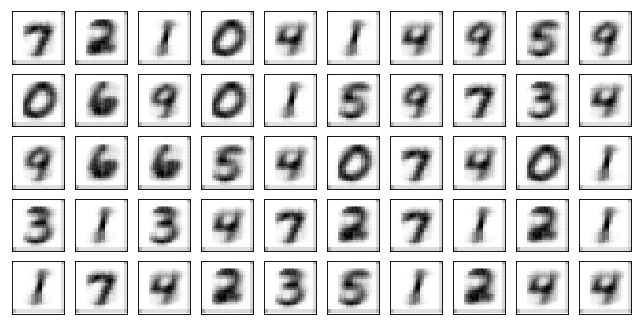

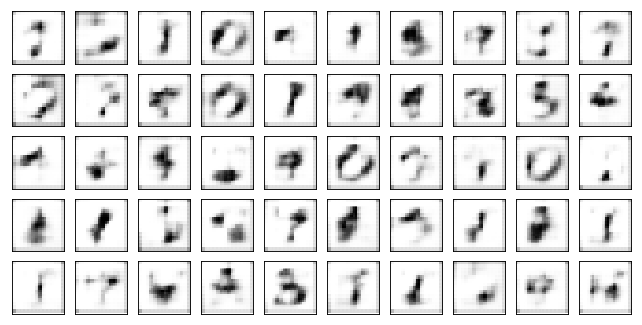

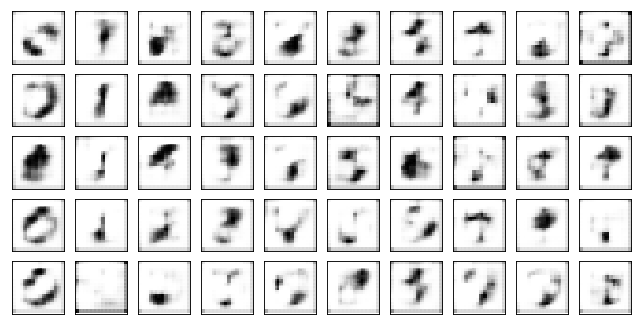

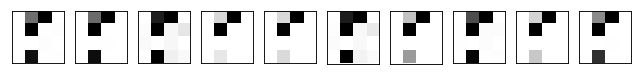

Model Adam Discr+bn+dp:


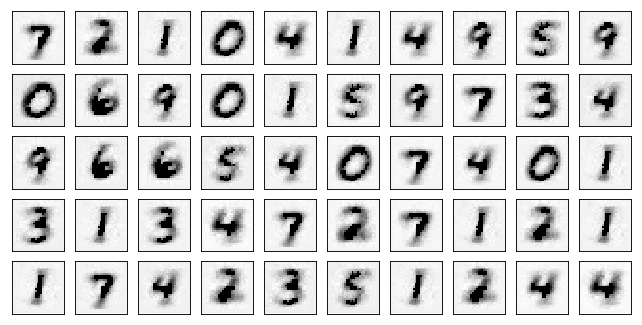

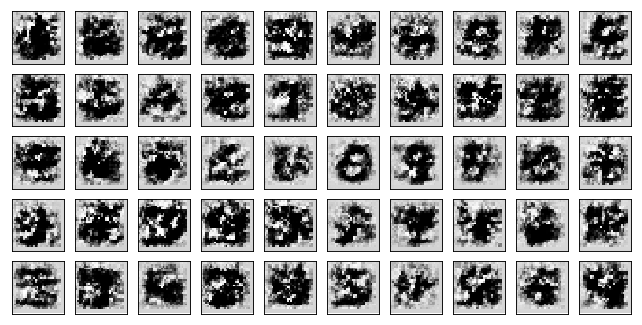

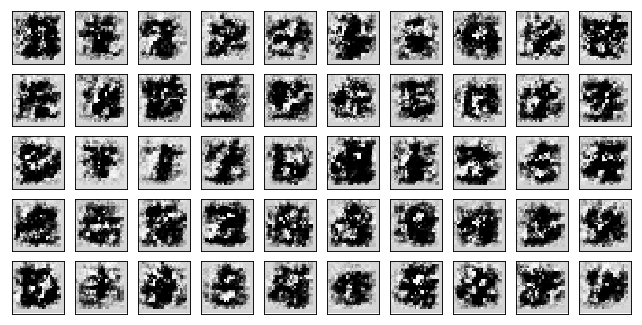

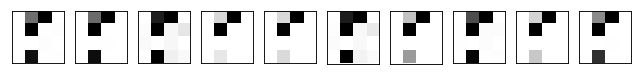

Test losses: 
Adam Discr: 1.14508867 / 47.99586487 / 0.00023863 
Adam Discr+bn+dp: 1.66755390 / 45.29561996 / 0.00135946 

Train Epoch: 5 [0/50000 (0%)]	Losses Adam Discr: AE:9.2756 D:0.0002 Adam Discr+bn+dp: AE:9.2734 D:0.0029
Train Epoch: 5 [10000/50000 (20%)]	Losses Adam Discr: AE:10.9718 D:0.0001 Adam Discr+bn+dp: AE:8.4854 D:0.0003
Train Epoch: 5 [20000/50000 (40%)]	Losses Adam Discr: AE:10.6025 D:0.0000 Adam Discr+bn+dp: AE:9.2754 D:0.0008
Train Epoch: 5 [30000/50000 (60%)]	Losses Adam Discr: AE:11.2386 D:0.0000 Adam Discr+bn+dp: AE:10.2950 D:0.0001
Train Epoch: 5 [40000/50000 (80%)]	Losses Adam Discr: AE:11.2797 D:0.0000 Adam Discr+bn+dp: AE:9.0335 D:0.0007
Train Epoch: 5 [50000/50000 (100%)]	Losses Adam Discr: AE:11.3161 D:0.0000 Adam Discr+bn+dp: AE:8.2893 D:0.0003
Model Adam Discr:


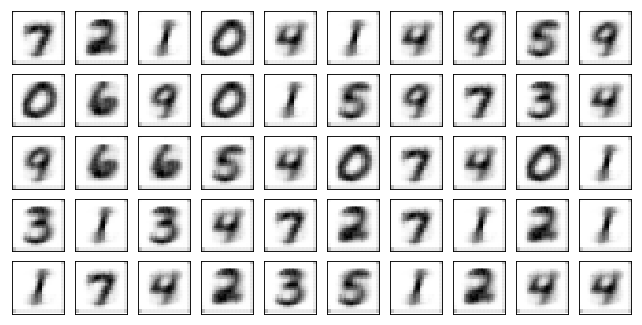

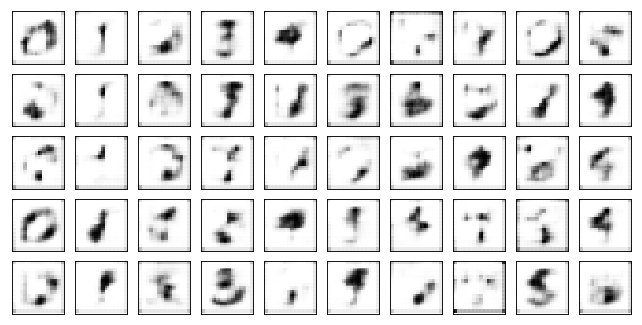

Model Adam Discr+bn+dp:


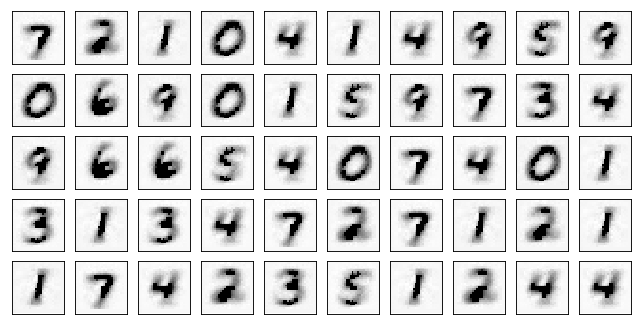

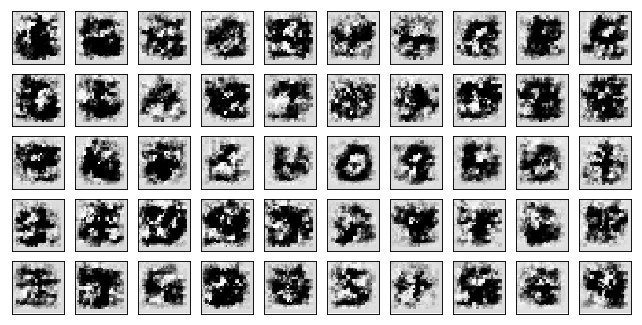

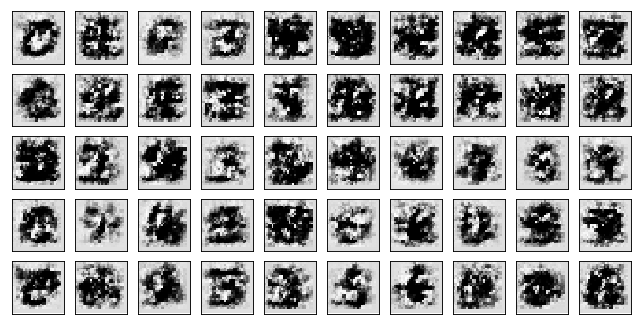

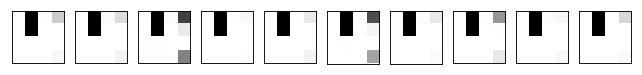

Test losses: 
Adam Discr: 1.11464953 / 56.38141632 / 0.00021916 
Adam Discr+bn+dp: 1.56329727 / 40.43014908 / 0.00122230 

Train Epoch: 6 [0/50000 (0%)]	Losses Adam Discr: AE:11.0922 D:0.0000 Adam Discr+bn+dp: AE:8.1852 D:0.0006
Train Epoch: 6 [10000/50000 (20%)]	Losses Adam Discr: AE:11.0160 D:0.0000 Adam Discr+bn+dp: AE:9.4148 D:0.0001
Train Epoch: 6 [20000/50000 (40%)]	Losses Adam Discr: AE:9.0581 D:0.1312 Adam Discr+bn+dp: AE:10.4566 D:0.0001
Train Epoch: 6 [30000/50000 (60%)]	Losses Adam Discr: AE:7.5621 D:0.0007 Adam Discr+bn+dp: AE:9.0299 D:0.0001
Train Epoch: 6 [40000/50000 (80%)]	Losses Adam Discr: AE:8.7386 D:0.0005 Adam Discr+bn+dp: AE:11.0059 D:0.0001
Train Epoch: 6 [50000/50000 (100%)]	Losses Adam Discr: AE:8.0375 D:0.0008 Adam Discr+bn+dp: AE:9.3663 D:0.0001
Model Adam Discr:


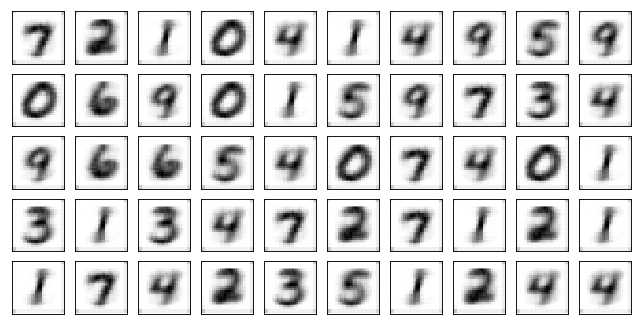

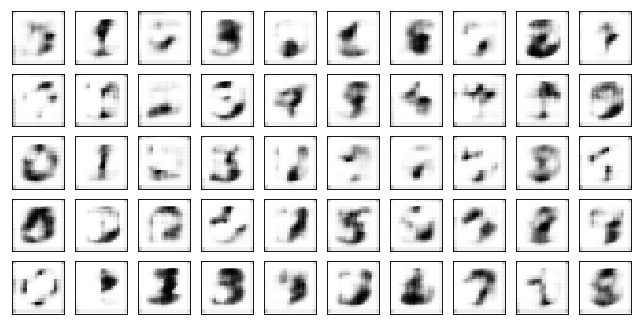

Model Adam Discr+bn+dp:


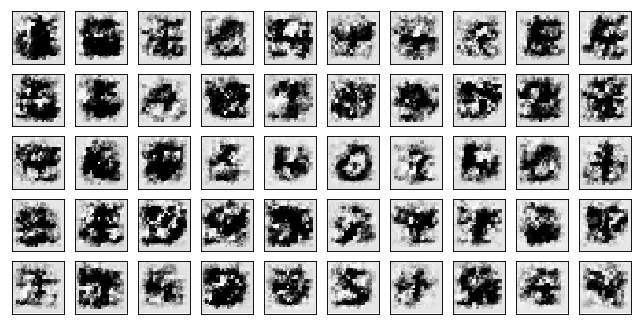

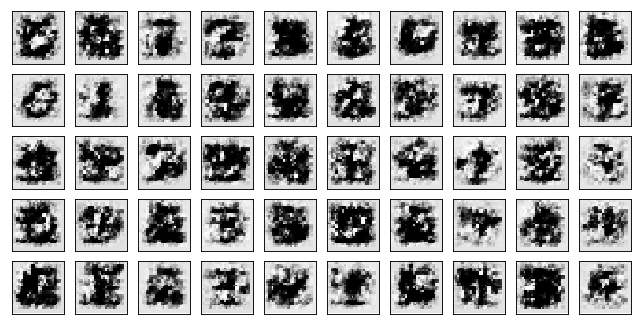

Test losses: 
Adam Discr: 1.10361600 / 41.09930801 / 0.00122215 
Adam Discr+bn+dp: 1.48377061 / 47.44746399 / 0.00495488 

Train Epoch: 7 [0/50000 (0%)]	Losses Adam Discr: AE:8.3310 D:0.0003 Adam Discr+bn+dp: AE:9.0602 D:0.0004
Train Epoch: 7 [10000/50000 (20%)]	Losses Adam Discr: AE:8.7677 D:0.0001 Adam Discr+bn+dp: AE:9.2638 D:0.0003
Train Epoch: 7 [20000/50000 (40%)]	Losses Adam Discr: AE:8.6301 D:0.0003 Adam Discr+bn+dp: AE:9.4295 D:0.0002
Train Epoch: 7 [30000/50000 (60%)]	Losses Adam Discr: AE:8.8781 D:0.0001 Adam Discr+bn+dp: AE:9.4181 D:0.0002
Train Epoch: 7 [40000/50000 (80%)]	Losses Adam Discr: AE:9.2489 D:0.0001 Adam Discr+bn+dp: AE:9.5437 D:0.0001
Train Epoch: 7 [50000/50000 (100%)]	Losses Adam Discr: AE:9.7472 D:0.0001 Adam Discr+bn+dp: AE:9.2181 D:0.0003
Model Adam Discr:


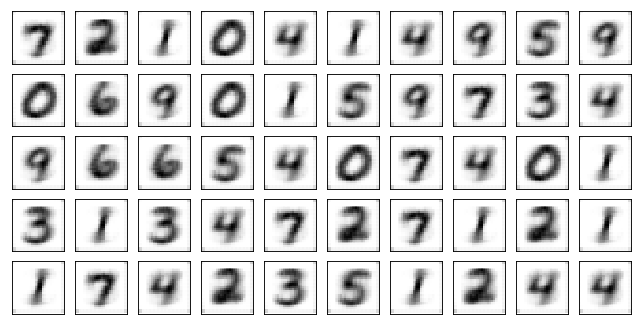

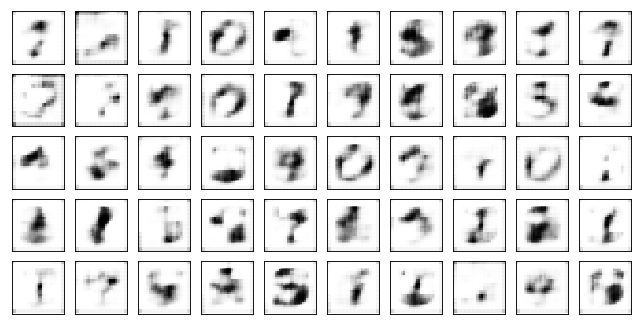

Model Adam Discr+bn+dp:


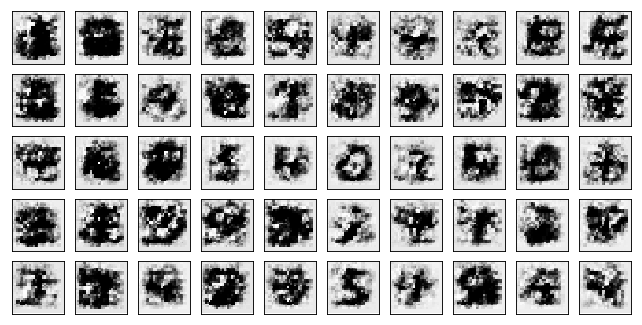

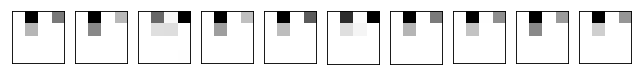

Test losses: 
Adam Discr: 1.09295070 / 48.01967239 / 0.00042365 
Adam Discr+bn+dp: 1.48256457 / 49.86403656 / 0.00067423 

Train Epoch: 8 [0/50000 (0%)]	Losses Adam Discr: AE:9.3755 D:0.0020 Adam Discr+bn+dp: AE:9.4775 D:0.0002
Train Epoch: 8 [10000/50000 (20%)]	Losses Adam Discr: AE:9.5474 D:0.0001 Adam Discr+bn+dp: AE:9.7991 D:0.0001
Train Epoch: 8 [20000/50000 (40%)]	Losses Adam Discr: AE:11.3494 D:0.0002 Adam Discr+bn+dp: AE:9.9206 D:0.0002
Train Epoch: 8 [30000/50000 (60%)]	Losses Adam Discr: AE:9.7817 D:0.0001 Adam Discr+bn+dp: AE:9.7092 D:0.0005
Train Epoch: 8 [40000/50000 (80%)]	Losses Adam Discr: AE:10.0200 D:0.0001 Adam Discr+bn+dp: AE:9.1202 D:0.0003
Train Epoch: 8 [50000/50000 (100%)]	Losses Adam Discr: AE:9.6708 D:0.0001 Adam Discr+bn+dp: AE:9.7236 D:0.0011
Model Adam Discr:


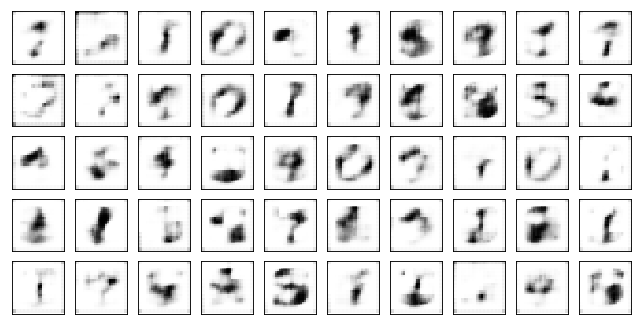

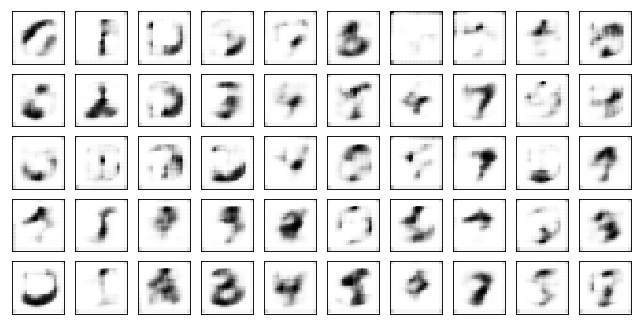

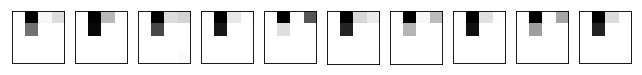

Model Adam Discr+bn+dp:


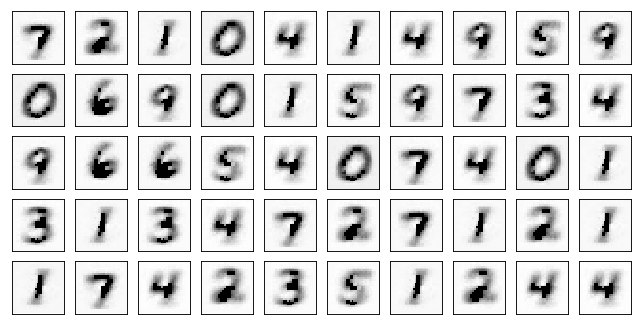

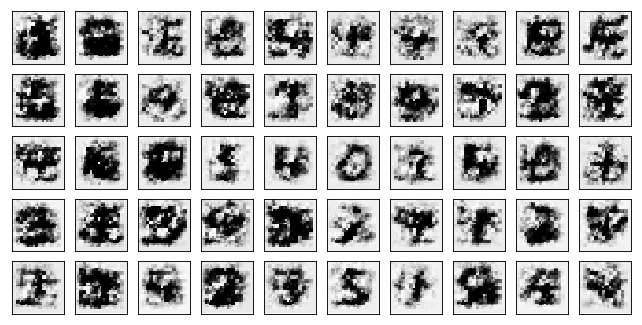

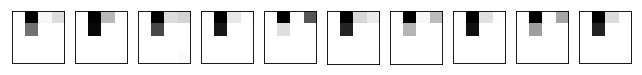

Test losses: 
Adam Discr: 1.08799374 / 49.65645981 / 0.00053615 
Adam Discr+bn+dp: 1.35567081 / 59.85888672 / 0.00014291 

Train Epoch: 9 [0/50000 (0%)]	Losses Adam Discr: AE:9.6642 D:0.0003 Adam Discr+bn+dp: AE:9.3738 D:0.0001
Train Epoch: 9 [10000/50000 (20%)]	Losses Adam Discr: AE:10.7181 D:0.0094 Adam Discr+bn+dp: AE:11.0989 D:0.0000
Train Epoch: 9 [20000/50000 (40%)]	Losses Adam Discr: AE:10.1530 D:0.0000 Adam Discr+bn+dp: AE:11.2248 D:0.0002
Train Epoch: 9 [30000/50000 (60%)]	Losses Adam Discr: AE:10.9265 D:0.0001 Adam Discr+bn+dp: AE:11.1921 D:0.0001
Train Epoch: 9 [40000/50000 (80%)]	Losses Adam Discr: AE:10.9442 D:0.0000 Adam Discr+bn+dp: AE:9.0574 D:0.0005
Train Epoch: 9 [50000/50000 (100%)]	Losses Adam Discr: AE:10.0374 D:0.0001 Adam Discr+bn+dp: AE:9.9491 D:0.0003
Model Adam Discr:


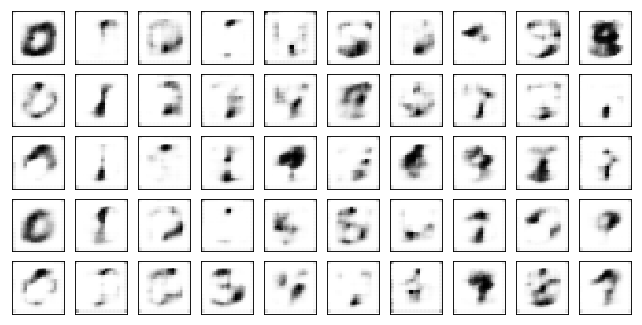

Model Adam Discr+bn+dp:


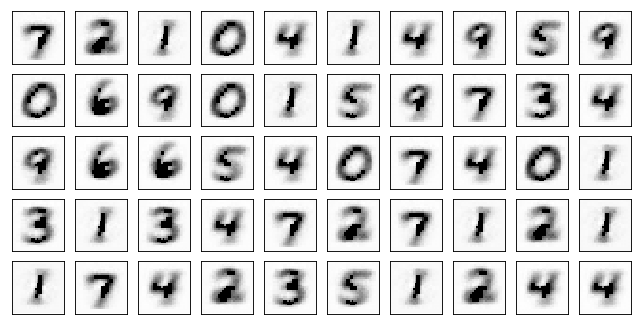

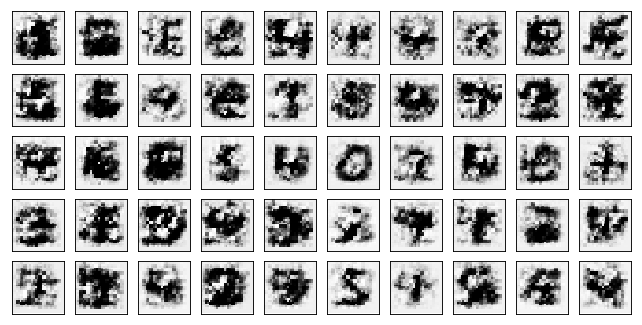

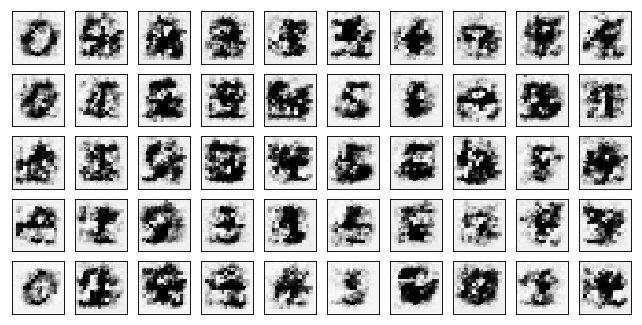

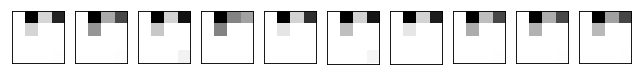

Test losses: 
Adam Discr: 1.08552349 / 52.03160477 / 0.00041324 
Adam Discr+bn+dp: 1.34418344 / 68.48739624 / 0.00203685 

Train Epoch: 10 [0/50000 (0%)]	Losses Adam Discr: AE:10.3529 D:0.0001 Adam Discr+bn+dp: AE:10.6150 D:0.0002
Train Epoch: 10 [10000/50000 (20%)]	Losses Adam Discr: AE:11.5407 D:0.0001 Adam Discr+bn+dp: AE:10.3134 D:0.0001
Train Epoch: 10 [20000/50000 (40%)]	Losses Adam Discr: AE:9.5230 D:0.0002 Adam Discr+bn+dp: AE:8.7748 D:0.0019
Train Epoch: 10 [30000/50000 (60%)]	Losses Adam Discr: AE:9.8696 D:0.0001 Adam Discr+bn+dp: AE:11.1154 D:0.0001
Train Epoch: 10 [40000/50000 (80%)]	Losses Adam Discr: AE:9.6332 D:0.0003 Adam Discr+bn+dp: AE:10.6863 D:0.0002
Train Epoch: 10 [50000/50000 (100%)]	Losses Adam Discr: AE:11.4165 D:0.0001 Adam Discr+bn+dp: AE:10.4124 D:0.0005
Model Adam Discr:


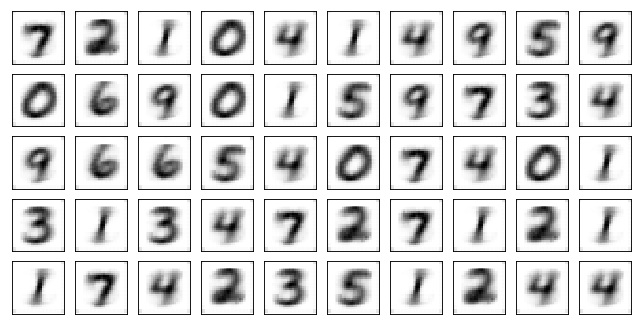

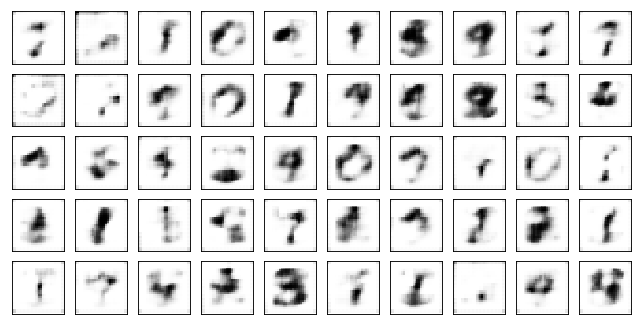

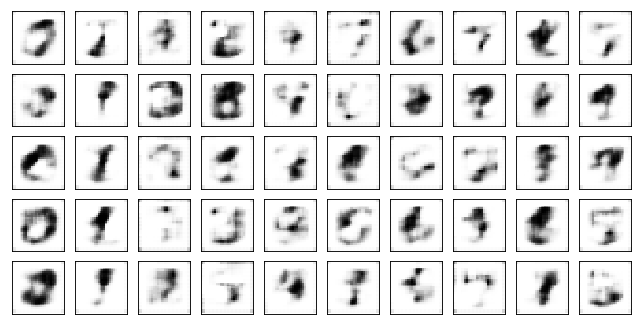

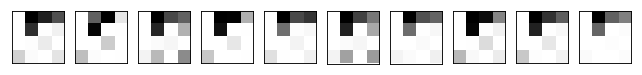

Model Adam Discr+bn+dp:


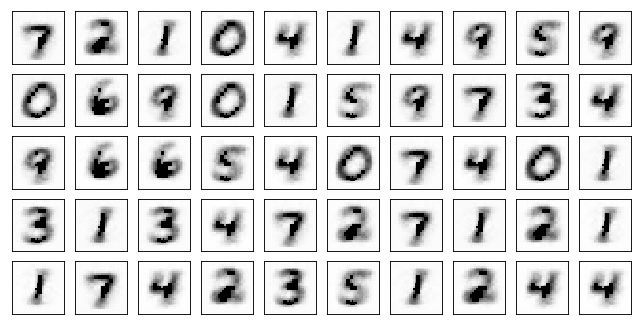

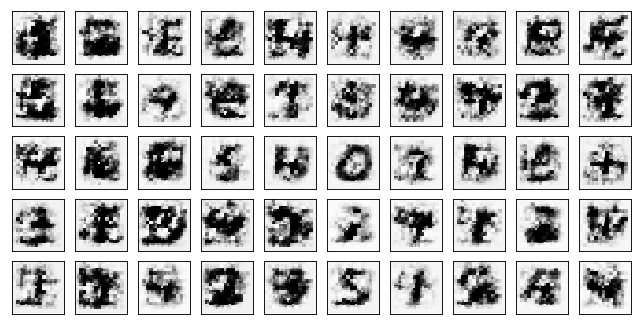

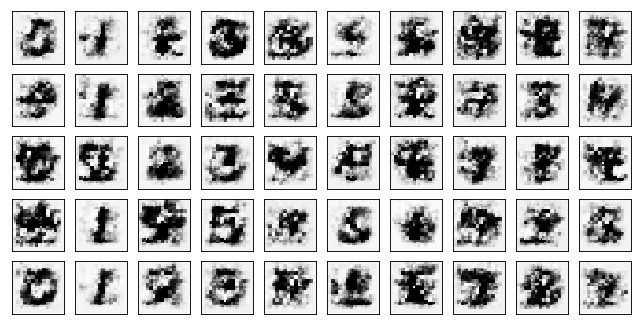

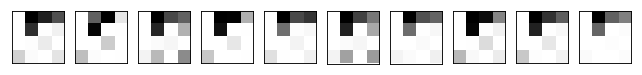

Test losses: 
Adam Discr: 1.08237004 / 56.24511719 / 0.00044896 
Adam Discr+bn+dp: 1.31187963 / 72.94797516 / 0.00194333 

Train Epoch: 11 [0/50000 (0%)]	Losses Adam Discr: AE:11.4228 D:0.0000 Adam Discr+bn+dp: AE:10.1270 D:0.0419
Train Epoch: 11 [10000/50000 (20%)]	Losses Adam Discr: AE:11.1341 D:0.0001 Adam Discr+bn+dp: AE:10.2616 D:0.0001
Train Epoch: 11 [20000/50000 (40%)]	Losses Adam Discr: AE:11.9771 D:0.0000 Adam Discr+bn+dp: AE:10.4330 D:0.0001
Train Epoch: 11 [30000/50000 (60%)]	Losses Adam Discr: AE:11.4843 D:0.0000 Adam Discr+bn+dp: AE:9.4364 D:0.0004
Train Epoch: 11 [40000/50000 (80%)]	Losses Adam Discr: AE:11.0241 D:0.0001 Adam Discr+bn+dp: AE:10.5527 D:0.0000
Train Epoch: 11 [50000/50000 (100%)]	Losses Adam Discr: AE:11.3408 D:0.0009 Adam Discr+bn+dp: AE:11.1107 D:0.0002
Model Adam Discr:


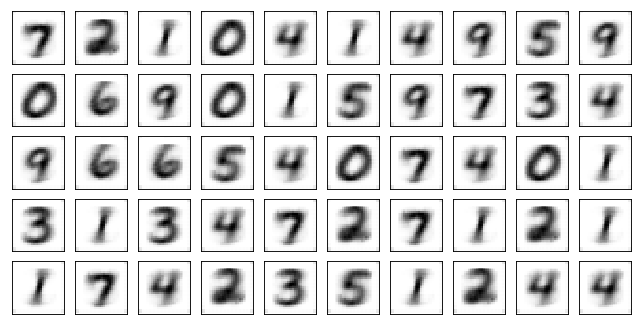

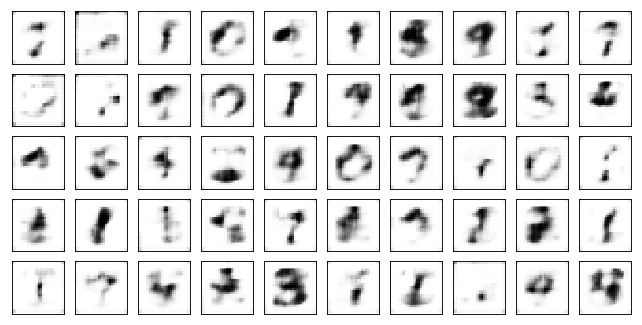

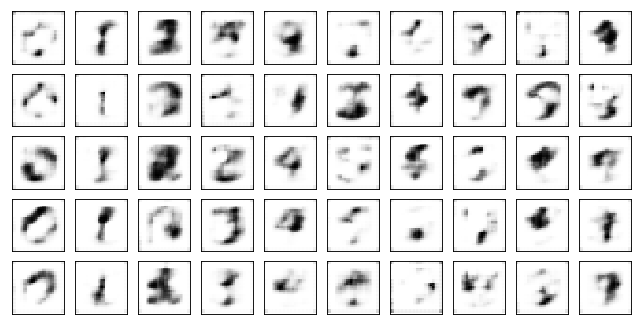

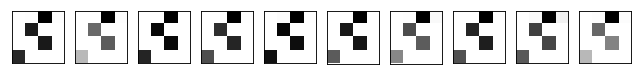

Model Adam Discr+bn+dp:


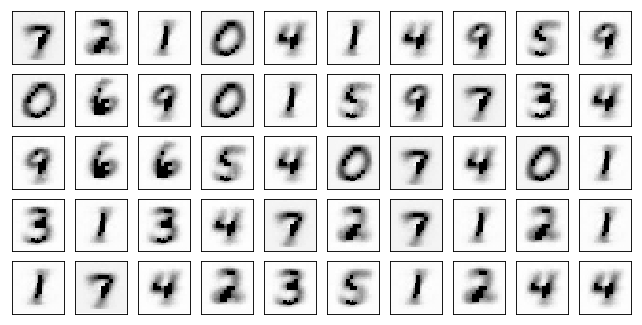

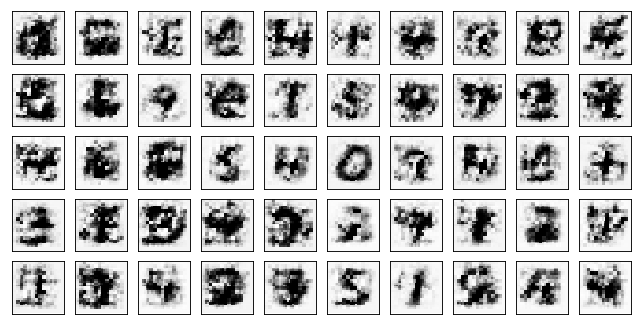

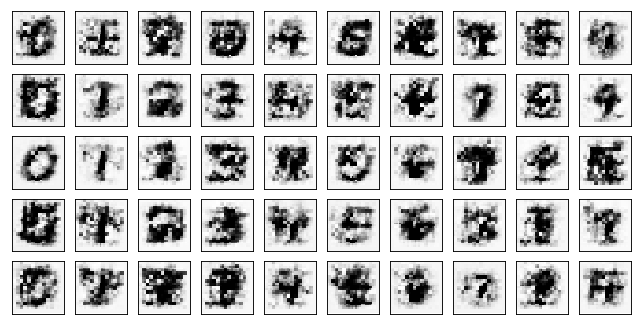

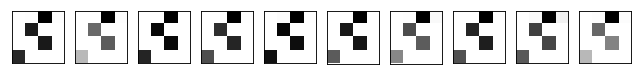

Test losses: 
Adam Discr: 1.08034968 / 56.55231857 / 0.00017116 
Adam Discr+bn+dp: 1.26857293 / 60.49309921 / 0.00188562 

Train Epoch: 12 [0/50000 (0%)]	Losses Adam Discr: AE:11.1054 D:0.0001 Adam Discr+bn+dp: AE:10.9946 D:0.0705
Train Epoch: 12 [10000/50000 (20%)]	Losses Adam Discr: AE:11.9448 D:0.0000 Adam Discr+bn+dp: AE:9.0727 D:0.0005
Train Epoch: 12 [20000/50000 (40%)]	Losses Adam Discr: AE:10.8489 D:0.0000 Adam Discr+bn+dp: AE:10.8930 D:0.0007
Train Epoch: 12 [30000/50000 (60%)]	Losses Adam Discr: AE:12.6834 D:0.0000 Adam Discr+bn+dp: AE:10.2649 D:0.0008
Train Epoch: 12 [40000/50000 (80%)]	Losses Adam Discr: AE:13.1013 D:0.0000 Adam Discr+bn+dp: AE:10.3489 D:0.0091
Train Epoch: 12 [50000/50000 (100%)]	Losses Adam Discr: AE:12.7927 D:0.0000 Adam Discr+bn+dp: AE:11.0137 D:0.0001
Model Adam Discr:


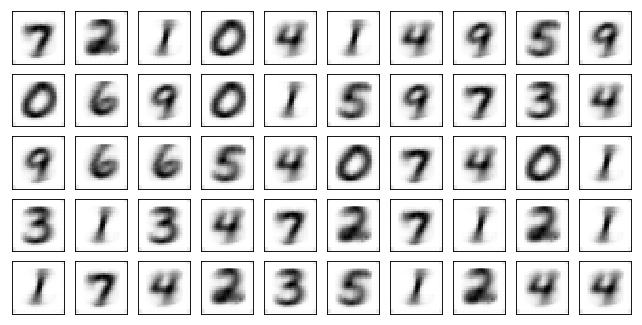

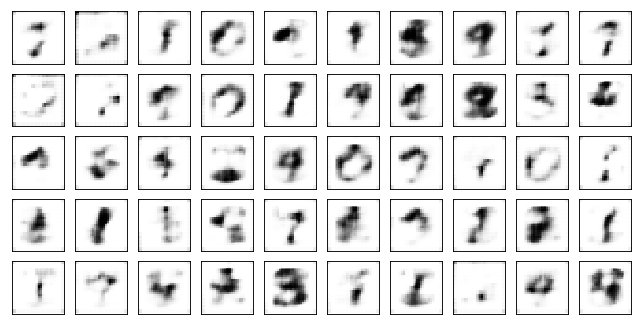

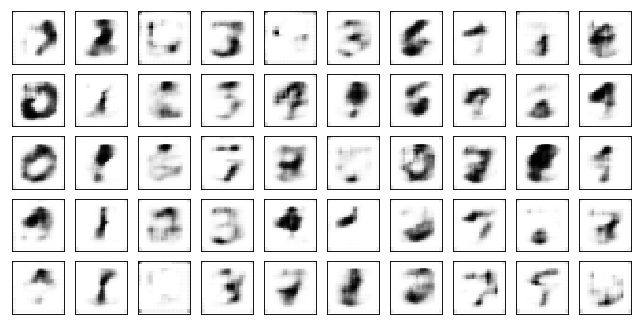

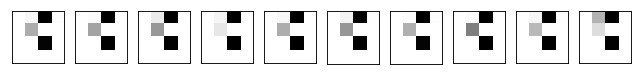

Model Adam Discr+bn+dp:


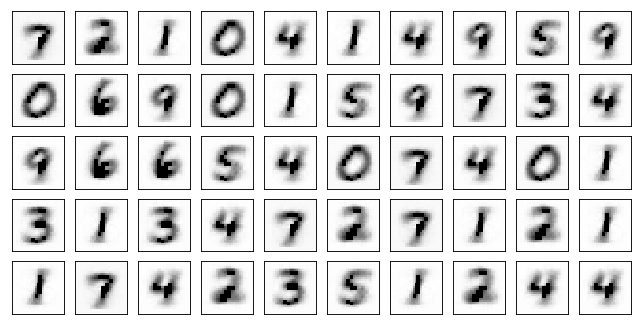

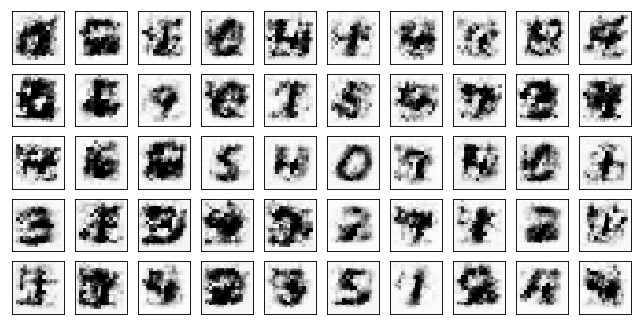

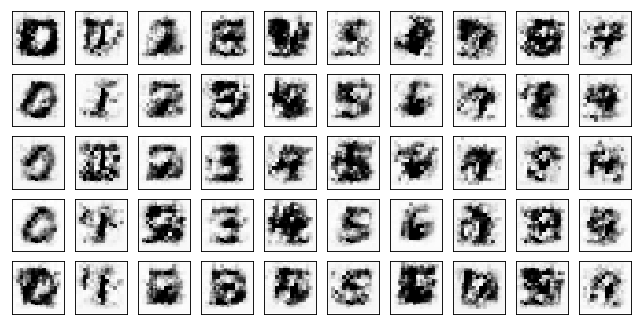

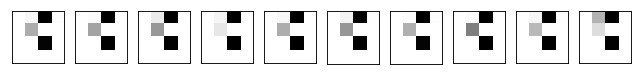

Test losses: 
Adam Discr: 1.07899451 / 64.39450836 / 0.00013096 
Adam Discr+bn+dp: 1.25752389 / 57.80500793 / 0.00183726 

Train Epoch: 13 [0/50000 (0%)]	Losses Adam Discr: AE:12.5945 D:0.0000 Adam Discr+bn+dp: AE:10.3773 D:0.0002
Train Epoch: 13 [10000/50000 (20%)]	Losses Adam Discr: AE:11.2124 D:0.0001 Adam Discr+bn+dp: AE:10.8829 D:0.0001
Train Epoch: 13 [20000/50000 (40%)]	Losses Adam Discr: AE:11.2667 D:0.0001 Adam Discr+bn+dp: AE:10.8648 D:0.0002
Train Epoch: 13 [30000/50000 (60%)]	Losses Adam Discr: AE:10.7780 D:0.0002 Adam Discr+bn+dp: AE:10.2983 D:0.0001
Train Epoch: 13 [40000/50000 (80%)]	Losses Adam Discr: AE:11.3791 D:0.0001 Adam Discr+bn+dp: AE:9.6808 D:0.0423
Train Epoch: 13 [50000/50000 (100%)]	Losses Adam Discr: AE:12.0604 D:0.0001 Adam Discr+bn+dp: AE:10.6101 D:0.0002
Model Adam Discr:


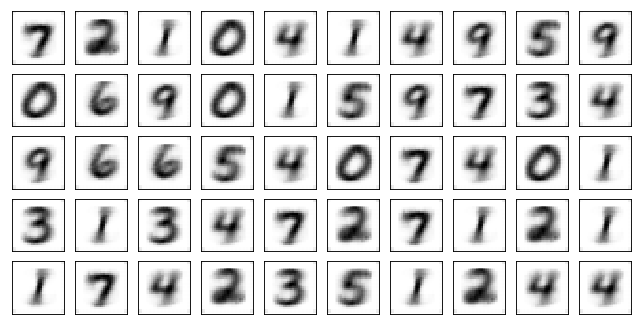

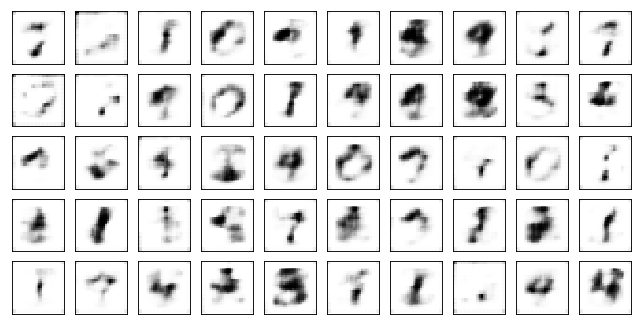

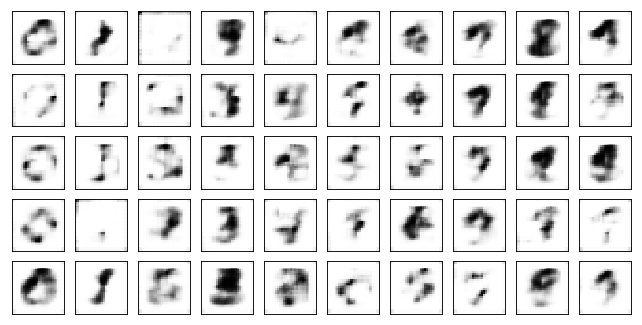

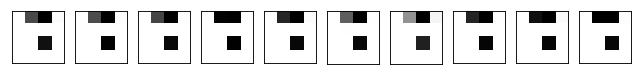

Model Adam Discr+bn+dp:


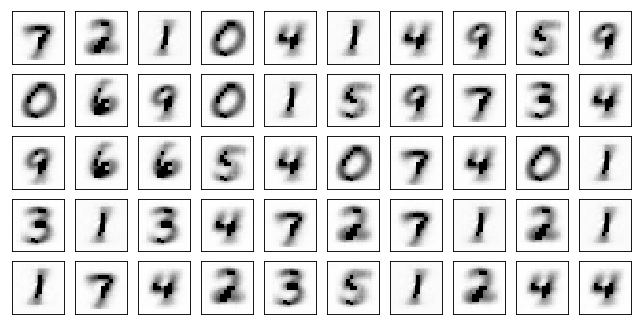

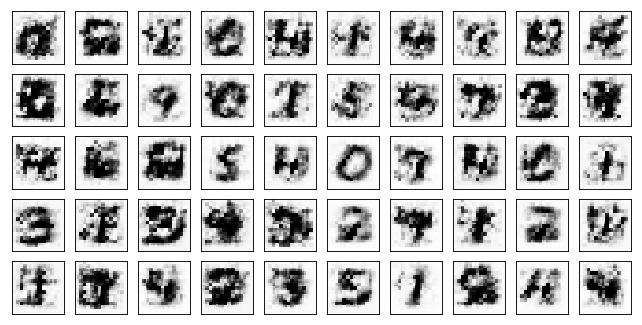

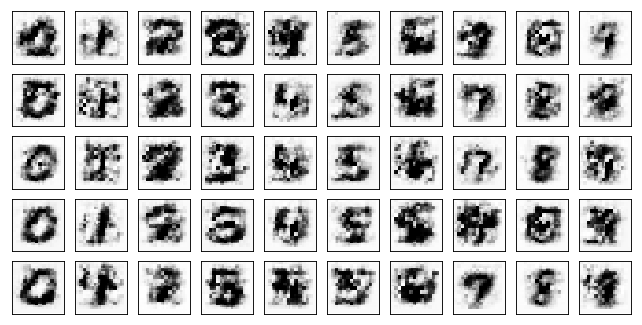

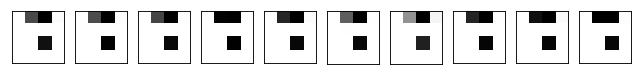

Test losses: 
Adam Discr: 1.07857776 / 60.30120468 / 0.00034987 
Adam Discr+bn+dp: 1.23460424 / 56.81097031 / 0.00174949 

Train Epoch: 14 [0/50000 (0%)]	Losses Adam Discr: AE:12.3301 D:0.0000 Adam Discr+bn+dp: AE:10.9545 D:0.0001
Train Epoch: 14 [10000/50000 (20%)]	Losses Adam Discr: AE:12.4642 D:0.0000 Adam Discr+bn+dp: AE:9.9381 D:0.0010
Train Epoch: 14 [20000/50000 (40%)]	Losses Adam Discr: AE:11.3326 D:0.0000 Adam Discr+bn+dp: AE:11.7332 D:0.0001
Train Epoch: 14 [30000/50000 (60%)]	Losses Adam Discr: AE:12.6573 D:0.0000 Adam Discr+bn+dp: AE:11.2106 D:0.0005
Train Epoch: 14 [40000/50000 (80%)]	Losses Adam Discr: AE:12.0559 D:0.0000 Adam Discr+bn+dp: AE:10.5976 D:0.0006
Train Epoch: 14 [50000/50000 (100%)]	Losses Adam Discr: AE:11.9088 D:0.0001 Adam Discr+bn+dp: AE:12.0277 D:0.0001
Model Adam Discr:


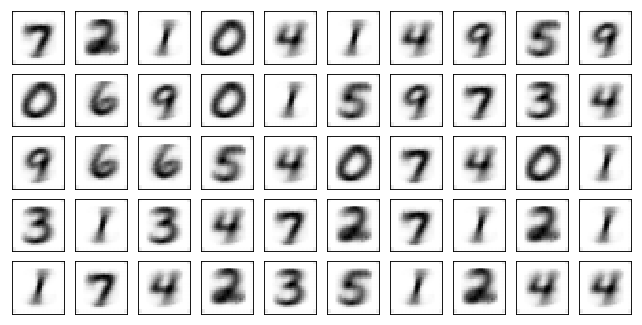

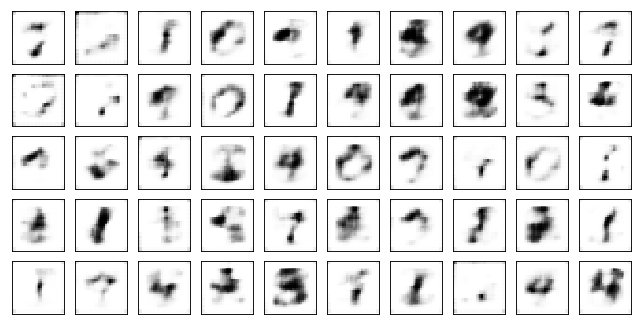

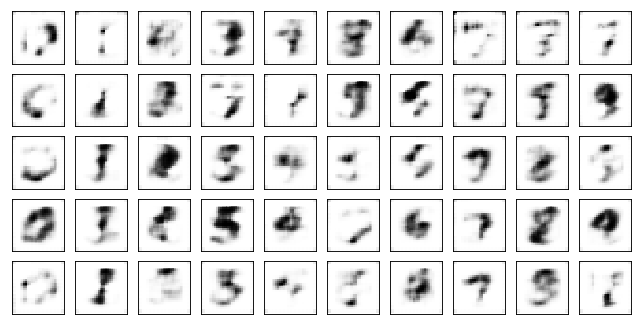

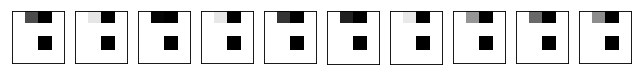

Model Adam Discr+bn+dp:


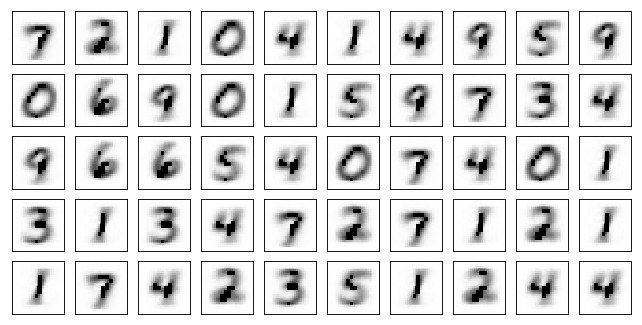

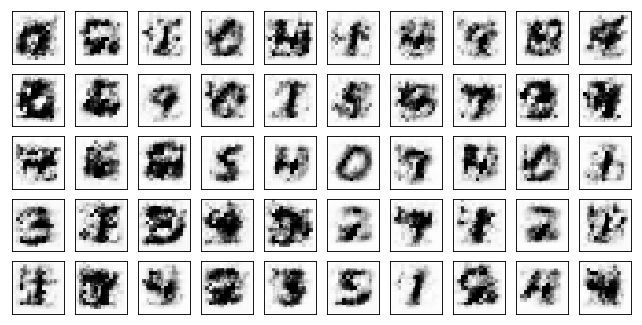

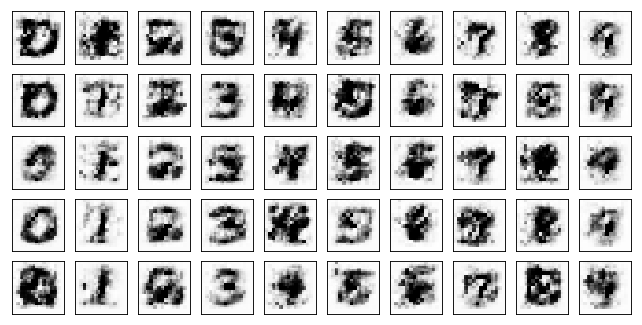

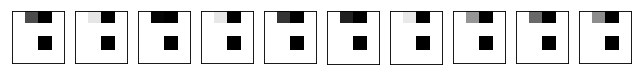

Test losses: 
Adam Discr: 1.07831621 / 59.18936539 / 0.00008835 
Adam Discr+bn+dp: 1.21985722 / 65.23619843 / 0.00285996 

Train Epoch: 15 [0/50000 (0%)]	Losses Adam Discr: AE:11.9453 D:0.0000 Adam Discr+bn+dp: AE:11.6340 D:0.0000
Train Epoch: 15 [10000/50000 (20%)]	Losses Adam Discr: AE:12.2362 D:0.0000 Adam Discr+bn+dp: AE:11.1207 D:0.0001
Train Epoch: 15 [20000/50000 (40%)]	Losses Adam Discr: AE:12.7196 D:0.0000 Adam Discr+bn+dp: AE:11.5929 D:0.0001
Train Epoch: 15 [30000/50000 (60%)]	Losses Adam Discr: AE:13.3216 D:0.0000 Adam Discr+bn+dp: AE:10.4527 D:0.0003


KeyboardInterrupt: 

In [15]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

In [ ]:
torch.save(models['Adam Discr+bn+dp'], './adam_ds_oh_1')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_oh_1')

### Вывод результатов

In [ ]:
model = torch.load('./adam_ds_oh')

In [ ]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(-1, 1).data.numpy()
    print ('enc=', encoded.shape)


In [ ]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [ ]:
def show_generated_samples():
    pred_z = torch.randn((50, 10))
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).data.numpy()  
    plot_mnist(generated, (5, 10))

In [ ]:
show_generated_samples()